In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

In [2]:
votes_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet")
users_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_user.parquet")
school_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_group.parquet")

In [31]:
# 날짜 정제
votes_df["vote_date"] = pd.to_datetime(votes_df["created_at"]).dt.date

# 해당 기간(4/28 ~ 5/25)에 투표한 유저 ID
target_user_ids = votes_df[
    (votes_df["vote_date"] >= pd.to_datetime("2023-04-29").date()) &
    (votes_df["vote_date"] <= pd.to_datetime("2023-05-25").date())
]["user_id"].unique()

# school_id가 존재하는 group만 추출
school_df_valid = school_df[school_df["school_id"].notnull()].copy()

# school_id를 유저에게 붙이기 (users → school_df)
users_with_school = users_df.merge(
    school_df_valid[["id", "school_id"]],
    left_on="group_id", right_on="id", how="left"
).drop(columns="id_y").rename(columns={"id_x": "user_id"})

# 해당 유저 중에서 위 기간에 투표한 유저만 필터링
target_users = users_with_school[users_with_school["user_id"].isin(target_user_ids)]

# 투표한 유저가 소속된 학교 ID들 (유니크)
active_school_ids = target_users["school_id"].dropna().unique()
print(" 해당 기간에 투표 발생한 학교 수:", len(active_school_ids))

# 이 학교 ID에 속한 전체 유저 수
final_user_count = users_with_school[
    users_with_school["school_id"].isin(active_school_ids)
]["user_id"].nunique()

print(" 해당 학교에 소속된 유저 수:", final_user_count)

 해당 기간에 투표 발생한 학교 수: 10
 해당 학교에 소속된 유저 수: 5090


In [32]:
# 해당 학교에 속한 유저 ID 목록
target_school_user_ids = users_with_school[
    users_with_school["school_id"].isin(active_school_ids)
]["user_id"].unique()

# 해당 유저 중에서 4/28 ~ 5/25 기간에 투표한 유저 수
voted_users_in_target_schools = votes_df[
    (votes_df["vote_date"] >= pd.to_datetime("2023-04-29").date()) &
    (votes_df["vote_date"] <= pd.to_datetime("2023-05-25").date()) &
    (votes_df["user_id"].isin(target_school_user_ids))
]["user_id"].nunique()

print(" 해당 10개 학교 유저 중 실제 투표한 유저 수:", voted_users_in_target_schools)


 해당 10개 학교 유저 중 실제 투표한 유저 수: 4703


In [33]:
# vote_date 파싱
votes_df["vote_date"] = pd.to_datetime(votes_df["created_at"]).dt.normalize()

# cohort_day (첫 투표일) 생성
cohort_df = votes_df.groupby("user_id")["vote_date"].min().reset_index(name="cohort_day")

# 대상 유저만 필터링 (4703명)
votes_filtered_df = votes_df[votes_df["user_id"].isin(target_user_ids)].copy()
votes_filtered_df = votes_filtered_df.merge(cohort_df, on="user_id", how="left")

# active_day 계산
votes_filtered_df["active_day"] = (votes_filtered_df["vote_date"] - votes_filtered_df["cohort_day"]).dt.days

# 기간 필터 (cohort_day 기준 4/29~5/25 사이)
votes_filtered_df = votes_filtered_df[
    (votes_filtered_df["cohort_day"] >= "2023-04-29") &
    (votes_filtered_df["cohort_day"] <= "2023-05-25") &
    (votes_filtered_df["active_day"] >= 0)
]

# cohort 크기 계산
cohort_size_df = votes_filtered_df.groupby("cohort_day")["user_id"].nunique().reset_index(name="cohort_size")

# active_day별 유지 유저 수
retained_df = votes_filtered_df.groupby(["cohort_day", "active_day"])["user_id"] \
    .nunique().reset_index(name="retained")

# 리텐션율 계산
ret_df = retained_df.merge(cohort_size_df, on="cohort_day")
ret_df["rate"] = ret_df["retained"] / ret_df["cohort_size"]


/tmp/ipykernel_388601/231352518.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=heat_25.applymap(lambda x: f"{x:.0%}"),


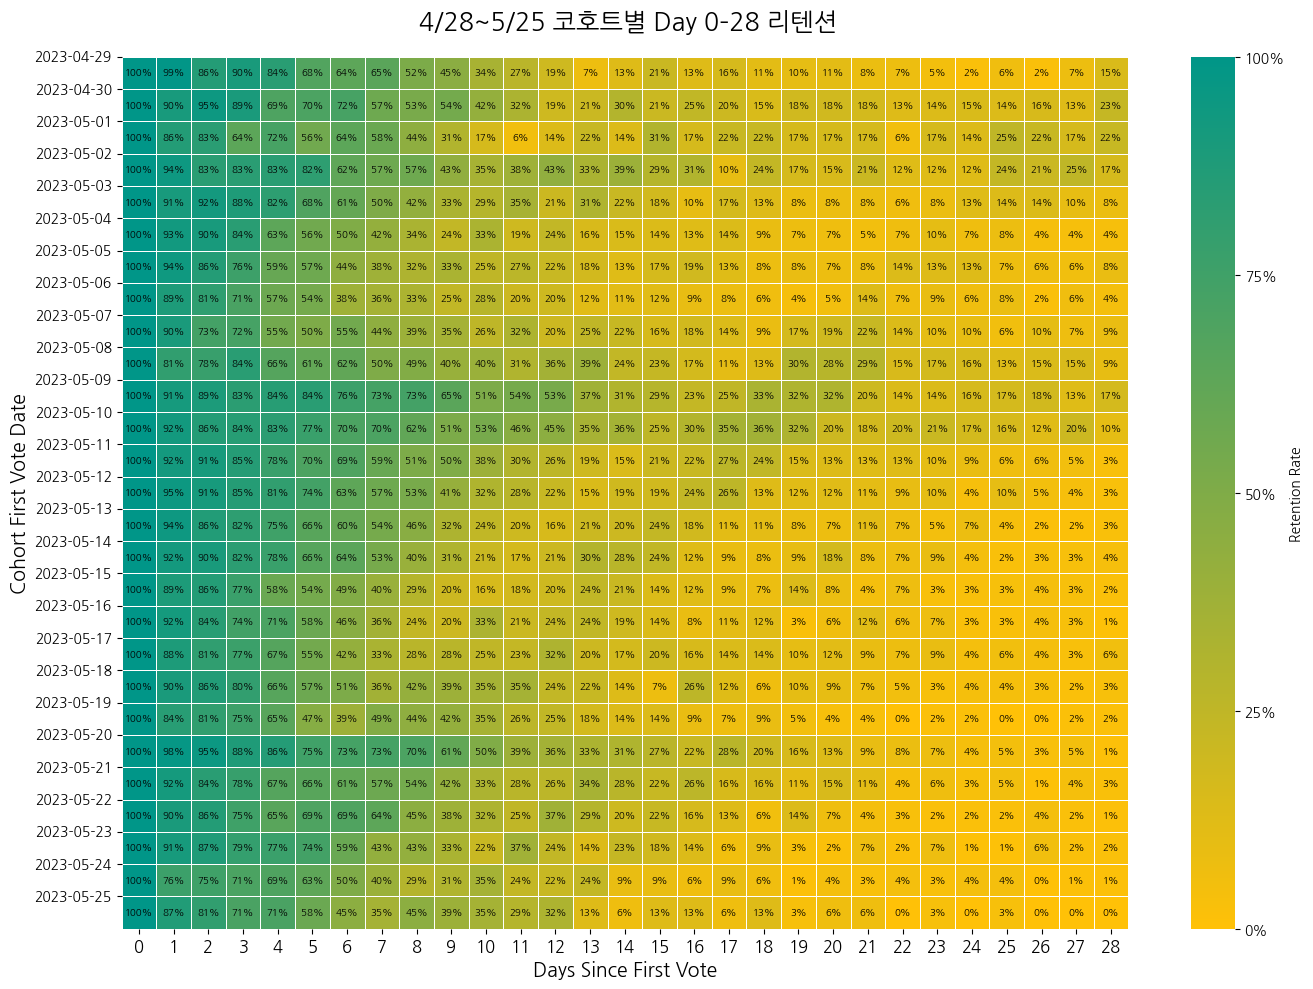

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib import ticker

# 피벗: Day 0~28까지만 시각화
heat_df = ret_df.pivot(index="cohort_day", columns="active_day", values="rate").fillna(0)
heat_25 = heat_df.loc[:, :28]

# 컬러맵 
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "team_palette", ["#ffc107", "#009688"], N=256
)

# 히트맵 생성
plt.figure(figsize=(14, 10))
sns.heatmap(
    heat_25,
    cmap=custom_cmap,
    annot=heat_25.applymap(lambda x: f"{x:.0%}"),
    fmt="",
    annot_kws={"size": 7, "color": "black"},
    linewidths=0.5,
    linecolor="white",
    vmin=0, vmax=1,
    cbar_kws={
        "label": "Retention Rate",
        "format": ticker.PercentFormatter(xmax=1, decimals=0),
        "ticks": [0, 0.25, 0.5, 0.75, 1.0]
    }
)

# 축 및 제목 설정
plt.xticks(rotation=0, fontsize=12)
plt.yticks(ticks=range(len(heat_25.index)), labels=heat_25.index.strftime('%Y-%m-%d'), rotation=0, fontsize=10)
plt.title(" 4/28~5/25 코호트별 Day 0–28 리텐션", fontsize=18, pad=20)
plt.xlabel("Days Since First Vote", fontsize=14)
plt.ylabel("Cohort First Vote Date", fontsize=14)

plt.tight_layout()
plt.show()


In [7]:
cohort_size_df["cohort_size"].sum()

4703

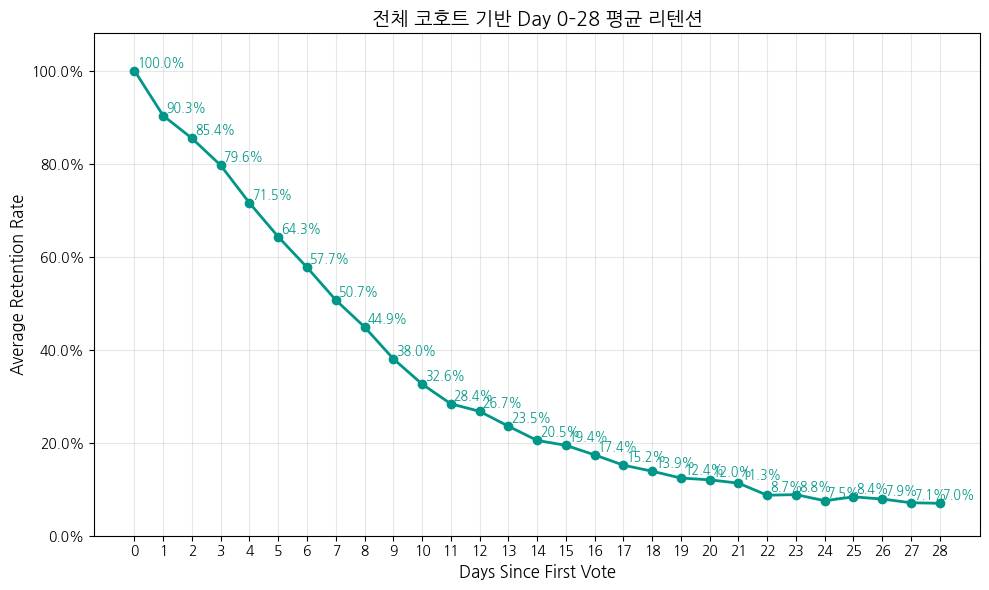

In [35]:
# 수치 추가 후 조절

from matplotlib import ticker

# 평균 리텐션 계산 (Day 0~28)
avg_retention = (
    ret_df[ret_df["active_day"] <= 28]
    .groupby("active_day")["rate"]
    .mean()
    .reset_index()
)

# 라인 그래프 
plt.figure(figsize=(10, 6))
plt.plot(
    avg_retention["active_day"],
    avg_retention["rate"],
    marker="o",
    color="#009688",  #
    linewidth=2,
    label="평균 리텐션율"
)

# 각 점 위에 수치 표시
# 수치 표시를 좀 더 보기 좋게 띄워서 추가
for x, y in zip(avg_retention["active_day"], avg_retention["rate"]):
    plt.text(x + 0.1, y + 0.03, f"{y:.1%}", ha="left", va="top", fontsize=9, color="#009688")



# 레이블/그리드/포맷 설정
plt.xticks(range(0, 29))
plt.xlabel("Days Since First Vote", fontsize=12)
plt.ylabel("Average Retention Rate", fontsize=12)
plt.title("전체 코호트 기반 Day 0–28 평균 리텐션", fontsize=14)
plt.grid(alpha=0.3)
plt.ylim(0, 1.08)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
plt.tight_layout()
plt.show()

In [36]:
avg_retention

,active_day,rate
0,0,1.000000
1,1,0.903003
2,2,0.854351
3,3,0.796214
4,4,0.715377
5,5,0.642568
6,6,0.576989
7,7,0.506709
8,8,0.448789
9,9,0.380471


# 마스터 테이블 

In [9]:
# 날짜 파싱
votes_df["vote_date"] = pd.to_datetime(votes_df["created_at"]).dt.date

# 기간 필터링: 4월 28일 ~ 5월 25일
votes_filtered_df = votes_df[
    (votes_df["vote_date"] >= pd.to_datetime("2023-04-29").date()) &
    (votes_df["vote_date"] <= pd.to_datetime("2023-05-25").date())
].copy()

In [10]:
# school_id가 존재하는 group만 필터링
school_df_valid = school_df[school_df["school_id"].notnull()].copy()

# 유저와 school 정보 연결
users_with_school = users_df.merge(
    school_df_valid[["id", "school_id"]],
    left_on="group_id", right_on="id", how="left"
).drop(columns="id_y").rename(columns={"id_x": "user_id"})

# 해당 기간에 투표한 유저 ID
target_user_ids = votes_filtered_df["user_id"].unique()

# 이 유저들 중 소속 학교 ID들 추출
target_users = users_with_school[users_with_school["user_id"].isin(target_user_ids)]
active_school_ids = target_users["school_id"].dropna().unique()


In [11]:
# 해당 10개 학교에 속한 유저만 추출
target_school_user_ids = users_with_school[
    users_with_school["school_id"].isin(active_school_ids)
]["user_id"].unique()

# 최종 유저로 vote 데이터 다시 필터링
votes_filtered_df = votes_filtered_df[
    votes_filtered_df["user_id"].isin(target_school_user_ids)
].copy()


In [12]:
# 유저별 행동 요약 집계
master_df = votes_filtered_df.groupby("user_id").agg(
    total_votes=("question_piece_id", "count"),
    unique_days=("vote_date", "nunique"),
    first_vote=("vote_date", "min"),
    last_vote=("vote_date", "max")
).reset_index()

# 활동 기간 추가 (일 단위)
master_df["active_days"] = (pd.to_datetime(master_df["last_vote"]) - pd.to_datetime(master_df["first_vote"])).dt.days


In [13]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days
0,838023,22,5,2023-04-29,2023-05-04,5
1,838466,127,6,2023-05-02,2023-05-07,5
2,838642,1,1,2023-04-29,2023-04-29,0
3,839357,205,8,2023-04-29,2023-05-07,8
4,840293,170,7,2023-05-03,2023-05-15,12
...,...,...,...,...,...,...
4698,1510561,9,1,2023-05-25,2023-05-25,0
4699,1511957,8,1,2023-05-25,2023-05-25,0
4700,1512422,22,1,2023-05-25,2023-05-25,0
4701,1512542,7,1,2023-05-25,2023-05-25,0


In [14]:
# cohort_day 컬럼 생성
master_df["cohort_day"] = pd.to_datetime(master_df["first_vote"])


In [15]:
master_df["cohort_day"]

0      2023-04-29
1      2023-05-02
2      2023-04-29
3      2023-04-29
4      2023-05-03
          ...    
4698   2023-05-25
4699   2023-05-25
4700   2023-05-25
4701   2023-05-25
4702   2023-05-25
Name: cohort_day, Length: 4703, dtype: datetime64[ns]

In [16]:
#  Day 7 리텐션 정보만 추출
day7_ret_df = ret_df[ret_df["active_day"] == 7][["cohort_day", "rate"]].copy()
day7_ret_df.rename(columns={"rate": "retention_day7"}, inplace=True)


In [17]:
#  cohort_day 기준으로 리텐션 정보 병합
master_df = master_df.merge(day7_ret_df, on="cohort_day", how="left")


In [18]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day7
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.646465
1,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444
2,838642,1,1,2023-04-29,2023-04-29,0,2023-04-29,0.646465
3,839357,205,8,2023-04-29,2023-05-07,8,2023-04-29,0.646465
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.501305
...,...,...,...,...,...,...,...,...
4698,1510561,9,1,2023-05-25,2023-05-25,0,2023-05-25,0.354839
4699,1511957,8,1,2023-05-25,2023-05-25,0,2023-05-25,0.354839
4700,1512422,22,1,2023-05-25,2023-05-25,0,2023-05-25,0.354839
4701,1512542,7,1,2023-05-25,2023-05-25,0,2023-05-25,0.354839


In [19]:
# 리텐션 그룹 컬럼 생성
master_df["ret_group"] = master_df["retention_day7"].apply(
    lambda x: "50 이상" if x >= 0.5 else "50 미만"
)

In [20]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day7,ret_group
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.646465,50 이상
1,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444,50 이상
2,838642,1,1,2023-04-29,2023-04-29,0,2023-04-29,0.646465,50 이상
3,839357,205,8,2023-04-29,2023-05-07,8,2023-04-29,0.646465,50 이상
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.501305,50 이상
...,...,...,...,...,...,...,...,...,...
4698,1510561,9,1,2023-05-25,2023-05-25,0,2023-05-25,0.354839,50 미만
4699,1511957,8,1,2023-05-25,2023-05-25,0,2023-05-25,0.354839,50 미만
4700,1512422,22,1,2023-05-25,2023-05-25,0,2023-05-25,0.354839,50 미만
4701,1512542,7,1,2023-05-25,2023-05-25,0,2023-05-25,0.354839,50 미만


In [21]:
# 리텐션 그룹 별로 분리된 컬럼 생성
master_df["ret_group_over"] = master_df["ret_group"].apply(
    lambda x: "50 이상" if x == "50 이상" else None
)

master_df["ret_group_under"] = master_df["ret_group"].apply(
    lambda x: "50 미만" if x == "50 미만" else None
)

In [22]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day7,ret_group,ret_group_over,ret_group_under
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.646465,50 이상,50 이상,None
1,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444,50 이상,50 이상,None
2,838642,1,1,2023-04-29,2023-04-29,0,2023-04-29,0.646465,50 이상,50 이상,None
3,839357,205,8,2023-04-29,2023-05-07,8,2023-04-29,0.646465,50 이상,50 이상,None
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.501305,50 이상,50 이상,None
...,...,...,...,...,...,...,...,...,...,...,...
4698,1510561,9,1,2023-05-25,2023-05-25,0,2023-05-25,0.354839,50 미만,None,50 미만
4699,1511957,8,1,2023-05-25,2023-05-25,0,2023-05-25,0.354839,50 미만,None,50 미만
4700,1512422,22,1,2023-05-25,2023-05-25,0,2023-05-25,0.354839,50 미만,None,50 미만
4701,1512542,7,1,2023-05-25,2023-05-25,0,2023-05-25,0.354839,50 미만,None,50 미만


In [23]:
master_df["ret_group_over"].count()

3083

In [24]:
master_df["ret_group_under"].count()

1620

In [25]:
# 이미 확보된 기준 유저 목록: target_user_ids (4703명)
# user_meta_df 생성 (기존 방식)
user_meta_df = users_df[["id", "gender", "group_id"]].rename(columns={"id": "user_id"})
school_info_df = school_df.rename(columns={"id": "group_id"})[["group_id", "school_id", "grade"]]
user_meta_df = user_meta_df.merge(school_info_df, on="group_id", how="left")

# 필터링: 리텐션 대상 유저만 남기기
user_meta_df = user_meta_df[user_meta_df["user_id"].isin(target_user_ids)].copy()


In [26]:
user_meta_df

,user_id,gender,group_id,school_id,grade
396,838023,F,233.0,271.0,1.0
633,838466,F,321.0,369.0,2.0
756,838642,F,356.0,271.0,2.0
1252,839357,M,519.0,271.0,1.0
1889,840293,F,838.0,369.0,1.0
...,...,...,...,...,...
609083,1510561,M,73885.0,4426.0,2.0
610323,1511957,F,29558.0,5520.0,2.0
610738,1512422,F,72313.0,4426.0,2.0
610834,1512542,F,72313.0,4426.0,2.0


In [27]:
master_df = master_df.merge(user_meta_df, on="user_id", how="left")

In [29]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day7,ret_group,ret_group_over,ret_group_under,gender,group_id,school_id,grade
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.646465,50 이상,50 이상,None,F,233.0,271.0,1.0
1,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444,50 이상,50 이상,None,F,321.0,369.0,2.0
2,838642,1,1,2023-04-29,2023-04-29,0,2023-04-29,0.646465,50 이상,50 이상,None,F,356.0,271.0,2.0
3,839357,205,8,2023-04-29,2023-05-07,8,2023-04-29,0.646465,50 이상,50 이상,None,M,519.0,271.0,1.0
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.501305,50 이상,50 이상,None,F,838.0,369.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4698,1510561,9,1,2023-05-25,2023-05-25,0,2023-05-25,0.354839,50 미만,None,50 미만,M,73885.0,4426.0,2.0
4699,1511957,8,1,2023-05-25,2023-05-25,0,2023-05-25,0.354839,50 미만,None,50 미만,F,29558.0,5520.0,2.0
4700,1512422,22,1,2023-05-25,2023-05-25,0,2023-05-25,0.354839,50 미만,None,50 미만,F,72313.0,4426.0,2.0
4701,1512542,7,1,2023-05-25,2023-05-25,0,2023-05-25,0.354839,50 미만,None,50 미만,F,72313.0,4426.0,2.0


In [30]:
master_df.to_csv("최종 마스터 테이블.csv", index=False)